In [1]:
#autoreload 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import lightning as lt
import yaml

In [2]:
from models import AE
model = AE()
input = torch.randn(1, 16, 64, 64)  # Example input tensor
model.test_latent_shape(input)

Input shape: torch.Size([1, 16, 64, 64])
Latent shape: torch.Size([1, 128, 4, 4])
Flattened latent shape: torch.Size([1, 2048])
Output shape: torch.Size([1, 16, 64, 64])


/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from ml.inklabel_dataset import InkLabelDataset
segment_ids = yaml.safe_load(open('../configs/segment_ids.yaml', 'r'))
print(segment_ids['segment_ids'])
segments = [segment_ids['segment_ids']['segments'][0]]
SAMPLE_SIZE = 64
dataset = InkLabelDataset(segment_ids=segments,sample_size=SAMPLE_SIZE)
train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_Loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True,num_workers=27)
test_Loader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False,num_workers=27)
validation_Loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False,num_workers=27)

{'segments': ['20231210121321', '20231106155350', '20231005123336', '20230820203112', '20230620230619', '20230826170124', '20230702185753', '20230522215721', '20230531193658', '20230520175435', '20230903193206', '20230902141231', '20231007101615', '20230929220924', 'recto', 'verso', '20231016151000', '20231012184423', '20231031143850']}
Creating InkLabelDataset with 1 segments...


Found 1 data points for 1 provided segments.
Created 3605 samples from ink label with shapes (15872, 12544), (16, 15839, 12489) for segment 20231210121321
Created 3605 samples from ink labels.


In [5]:
trainer = lt.Trainer(max_epochs=500, accelerator="gpu", devices=1, callbacks=[lt.pytorch.callbacks.early_stopping.EarlyStopping(monitor="train_loss", patience=15, mode="min")])


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [6]:
trainer.fit(model, train_dataloaders=train_Loader, val_dataloaders=validation_Loader)
trainer.test(model, dataloaders=test_Loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | encoder   | Sequential    | 339 K  | train
1 | attention | SelfAttention | 99.6 K | train
2 | decoder   | Sequential    | 240 K  | train
3 | criterion | MSELoss       | 0      | train
----------------------------------------------------
679 K     Trainable params
0         Non-trainable params
679 K     Total params
2.718     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 66: 100%|██████████| 181/181 [00:05<00:00, 35.92it/s, v_num=34]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 90/90 [00:00<00:00, 340.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22007255256175995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22007255256175995}]

[autoreload of models.condDDPM failed: Traceback (most recent call last):
  File "/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/npopkov/vesuvius_gcml/notebooks/../models/condDDPM.py", line 128
    optimizer = optim.AdamW(, lr=3e-4, eps=1e-5)
 

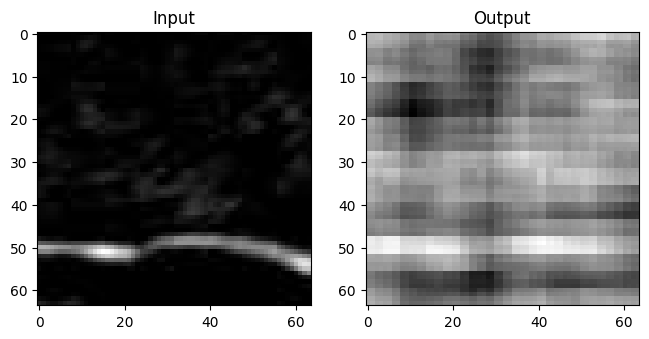

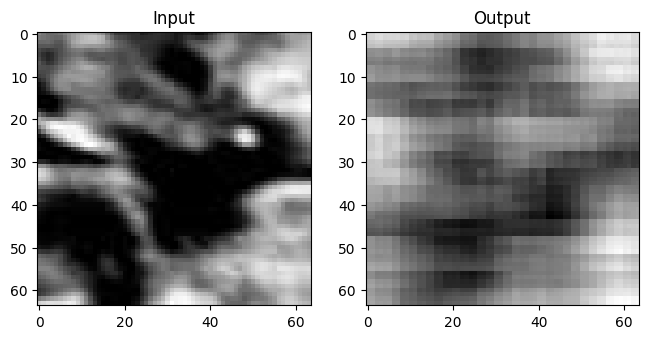

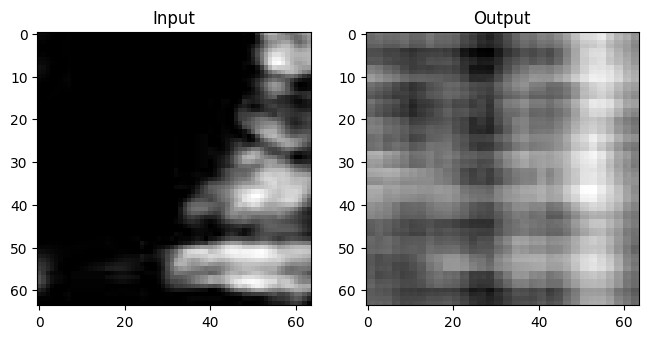

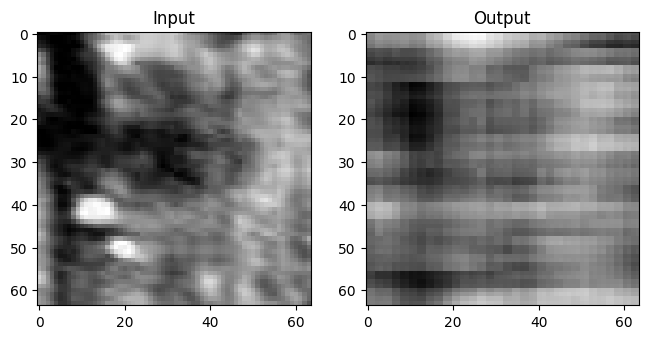

In [7]:
#print a example of the model output
import matplotlib.pyplot as plt

for batch in test_Loader:
    for idx in range(4):
        x = batch['scroll_segment'][idx]
        x = x.unsqueeze(0)  # Add batch dimension
       #x = x.unsqueeze(0)  # Add batch dimension
        #normalize the input
        x = (x - x.min()) / (x.max() - x.min())
        output = model(x)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Input')
        plt.imshow(x.squeeze()[0].cpu().numpy(), cmap='gray')
        
        plt.subplot(1, 3, 2)
        plt.title('Output')
        plt.imshow(output[0, 0].cpu().detach().numpy(), cmap='gray')
        
        plt.show()
    break

In [8]:
test = model.attention(model.encoder(x))
print(test.shape)
print(test.view(-1,128).shape)

torch.Size([1, 128, 4, 4])
torch.Size([16, 128])


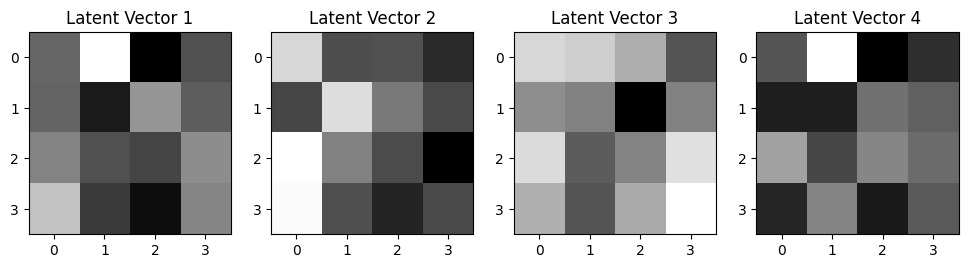

In [9]:
#show 4 latent vectors
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f'Latent Vector {i + 1}')
    plt.imshow(test.squeeze(0)[i+3].cpu().detach().numpy(), cmap='gray')

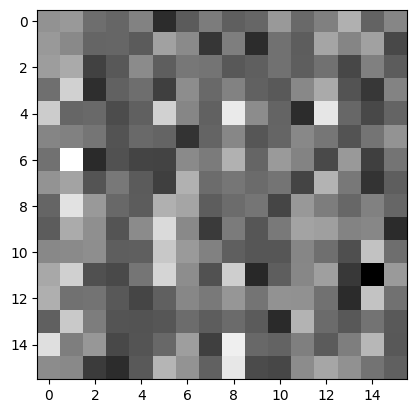

In [10]:
plt.imshow(test.view(-1,16,16)[0].cpu().detach().numpy(), cmap='gray')
plt.show()

In [ ]:
#save the model to a file
import os
if not os.path.exists('encoder_ckpt'):
    os.makedirs('encoder_ckpt')
torch.save(model.encoder.state_dict(), 'encoder_ckpt/encoder.pth')
torch.save(model.attention.state_dict(), 'encoder_ckpt/attention.pth')
